# KPIs

En esta libreta, partimos del dataframe que contiene toda la información de producción agrícola (SIAP), precios de mercado (SNIIM), IVF y variables climatólogicas.

Se generan nuevas columnas relaciondas a los KPIs.

### Importando librerías

In [29]:
import pandas as pd
import numpy as np
import os
import scipy.stats as st
from scipy.stats import moment, genextreme
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

### Cargando datos

In [30]:
directory = '../limpieza'

df = pd.read_csv(os.path.join(directory,"excedente_agrícola.csv"))

df.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,Estado_CVE,Temp_Superficial,Temp_Superficial_MAX,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf
0,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000,26.545455,18,19.612645,29.083726,13.741581,19.796194,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097,60.4,763.0
1,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000,5.830000,31,24.662450,30.634364,20.018247,24.568564,30.368262,19.961978,18.301996,21.435265,101.449988,0.637279,70.907876,0.629178,29.5,763.0
2,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000,12.181818,1,11.871672,24.617947,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100,38.5,138.1
3,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956,26.710000,2,11.503548,21.848387,5.296516,12.156581,19.138839,7.561161,3.232000,7.694516,96.414323,2.328968,60.059871,0.225097,4.3,138.1
4,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000,26.000000,3,18.086452,27.860968,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258,1.9,138.1


### Eficiencia

Este KPI nos dice el porcentaje de cultivo cosechado. El 100% nos diría que todo fue cosechado y nada siniestrado, el 0% que no hubo cosechada y el -1% indica que no hubo cosechada ni siniestrada. 

In [31]:
df['Eficiencia'] = df.apply(lambda row: \
                 (row['Superficie(ha)_Cosechada'] / (row['Superficie(ha)_Cosechada'] + \
                  row['Superficie(ha)_Siniestrada'])) * 100 \
                 if  (row['Superficie(ha)_Cosechada'] + row['Superficie(ha)_Siniestrada']) != 0 \
                 else -1.0, axis=1) 

### Índice de estrés térmico

In [32]:
df['Presión_Superficial'] = df['Presión_Superficial']*10 # de kp a hp
df.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,Estado_CVE,Temp_Superficial,Temp_Superficial_MAX,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf,Eficiencia
0,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000,26.545455,18,19.612645,29.083726,13.741581,19.796194,26.256194,14.834145,11.615113,15.705790,928.212419,1.488903,63.214177,2.056097,60.4,763.0,-1.0
1,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000,5.830000,31,24.662450,30.634364,20.018247,24.568564,30.368262,19.961978,18.301996,21.435265,1014.499878,0.637279,70.907876,0.629178,29.5,763.0,-1.0
2,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000,12.181818,1,11.871672,24.617947,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,792.692962,2.306334,59.219238,0.836100,38.5,138.1,-1.0
3,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956,26.710000,2,11.503548,21.848387,5.296516,12.156581,19.138839,7.561161,3.232000,7.694516,964.143226,2.328968,60.059871,0.225097,4.3,138.1,100.0
4,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000,26.000000,3,18.086452,27.860968,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,996.197419,2.680968,67.542323,0.050258,1.9,138.1,-1.0


In [33]:
# Crea una columna de indice de stress termico
df['Rango_Temp_2_Metros'] = (df['Temp_2_Metros_MAX'] - df['Temp_2_Metros_MIN'])
df['Indice_estres_termico'] = df['Rango_Temp_2_Metros']/max(df['Rango_Temp_2_Metros'])

### Evapotranspiración potencial (ETP)

In [34]:
Ro = 5.5 * 0.408 # Valor promedio historico de la constante de radiación solar para mexico
df['Evapotranspiracion'] = 0.043 * (df['Temp_Superficial'] + 17.78) * Ro * (df['Temp_Superficial_MAX'] - df['Temp_Superficial_MIN'])**0.5

### SPEI y Balance Hídrico
Basado en: https://github.com/monocongo/climate_indices y https://spei.csic.es/home.html

In [35]:
# Definir una función para calcular el balance hídrico climático (D)
def climatic_water_balance(precip, evpt):
    """ 
    Precip y pet son series de Pandas con los datos mensuales de precipitación y evapotranspiración potencial
     Devuelve una serie de Pandas con el balance hídrico climático (D) para cada mes """
    return precip - evpt

# Definir una función para ajustar una distribución log-logística a los datos de D
def log_logistic_fit(D):
    """ 
    D es una serie de Pandas con el balance hídrico climático
    Devuelve los parámetros de la distribución log-logística ajustada por el método de los momentos-L """
    # Calcular los momentos-L
    mean_d = np.mean(D)
    std_d = np.std(D)
    skewness_d = moment(D, moment=3) / np.power(std_d, 3)
    kurtosis_d = moment(D, moment=4) / np.power(std_d, 4) - 3

    # Calcular los parámetros de la distribución log-logística
    alpha = std_d * np.sqrt(6) / np.pi
    beta = skewness_d * np.power(alpha, 2) / 2
    gamma = mean_d - 0.5772 * alpha / beta

    return alpha, beta, gamma

# Definir una función para calcular el SPEI simplificado a partir de D y los parámetros de la distribución
def spei(D, alpha, beta, gamma):
    """ 
    D: balance hídrico climático
    # alpha, beta y gamma son los parámetros de la distribución log-logística """
    F = st.logistic.cdf(D, loc=gamma, scale=alpha)  # Eliminar el argumento 'c'
    P = 1 - F  # Calcular la probabilidad de no excedencia de D
    SPEI = st.norm.ppf(P)  # Aplicar la transformación inversa de la normal estándar
    return SPEI

balance = climatic_water_balance(df['Precipitacion'], df['Evapotranspiracion'])
fit = log_logistic_fit(balance)

df['Balance_Hidrico'] = balance
df['SPEI'] = spei(balance, fit[0], fit[1], fit[2])
df.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,Estado_CVE,Temp_Superficial,Temp_Superficial_MAX,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf,Eficiencia,Rango_Temp_2_Metros,Indice_estres_termico,Evapotranspiracion,Balance_Hidrico,SPEI
0,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000,26.545455,18,19.612645,29.083726,13.741581,19.796194,26.256194,14.834145,11.615113,15.705790,928.212419,1.488903,63.214177,2.056097,60.4,763.0,-1.0,11.422048,0.553102,14.132550,-12.076454,-0.315130
1,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000,5.830000,31,24.662450,30.634364,20.018247,24.568564,30.368262,19.961978,18.301996,21.435265,1014.499878,0.637279,70.907876,0.629178,29.5,763.0,-1.0,10.406284,0.503915,13.343649,-12.714470,-0.223872
2,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000,12.181818,1,11.871672,24.617947,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,792.692962,2.306334,59.219238,0.836100,38.5,138.1,-1.0,15.106657,0.731526,13.224927,-12.388827,-0.270526
3,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956,26.710000,2,11.503548,21.848387,5.296516,12.156581,19.138839,7.561161,3.232000,7.694516,964.143226,2.328968,60.059871,0.225097,4.3,138.1,100.0,11.577677,0.560639,11.495783,-11.270686,-0.429356
4,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000,26.000000,3,18.086452,27.860968,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,996.197419,2.680968,67.542323,0.050258,1.9,138.1,-1.0,10.997806,0.532559,13.685804,-13.635546,-0.091285


In [36]:
columnas = [
    'Superficie(ha)_Sembrada',
    'Superficie(ha)_Cosechada',
    'Superficie(ha)_Siniestrada',
    'Producción',
    'Rendimiento(udm/ha)',
    'Precio',
    'Temp_Superficial',
    'Temp_Superficial_MAX',
    'Temp_Superficial_MIN',
    'Temp_2_Metros',
    'Temp_2_Metros_MAX',
    'Temp_2_Metros_MIN',
    'Temp_2_Metros_Pto_Congelación',
    'Temp_2_Metros_Pto_Húmedo',
    'Presión_Superficial',
    'Velocidad_Viento',
    'Humedad_Relativa',
    'Precipitacion',
    'Precipitación',
    'Ivf',
    'Eficiencia',
    'Rango_Temp_2_Metros',
    'Indice_estres_termico',
    'Evapotranspiracion',
    'Balance_Hidrico',
    'SPEI'
]

columnas_interes = [
    'Superficie(ha)_Sembrada',
    'Superficie(ha)_Cosechada',
    'Superficie(ha)_Siniestrada',
    'Producción',
    'Rendimiento(udm/ha)',
    'Precio'
]

<Axes: >

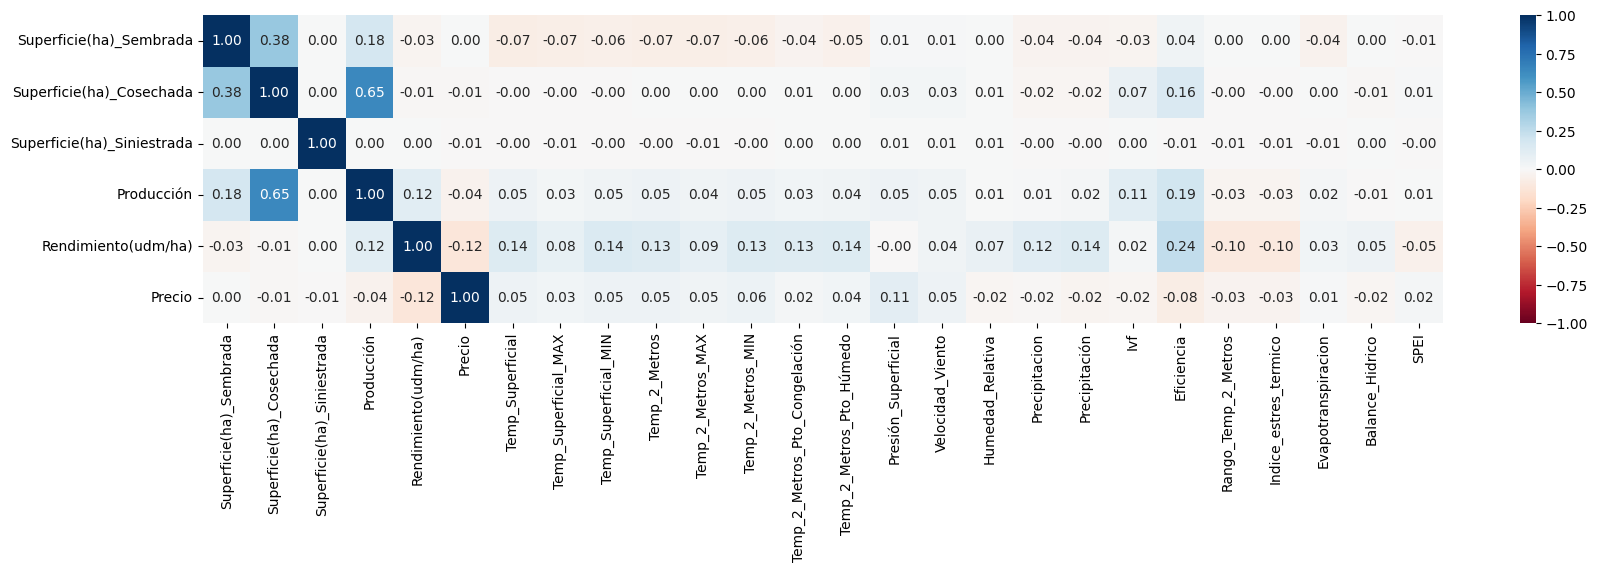

In [37]:
plt.figure(figsize = (20,4)) #cambiamos la variable quality_ord a int para calcular correlacion
corr_matrix = df[columnas].corr()
sns.heatmap(corr_matrix.loc[columnas_interes, columnas], annot=True,cmap='RdBu', fmt = '.2f', vmin=-1, vmax=1)

### Índice de Correlación AgroEconómica

In [38]:
# Cargando datos de correlación
directory = '../EDA/data'
df_corr_produccion_precio_anual = pd.read_csv(os.path.join(directory,"df_corr_produccion_precio_anual.csv"))
#df_corr_produccion_precio_anual.head()

In [39]:
# Se renombra la columna de correlación por el nombre del KPI
df_corr_produccion_precio_anual.rename(columns={"Corr_Producción_Precio":"ICAE"}, inplace=True)
df_corr_produccion_precio_anual

,Estado,Cultivo,Año,ICAE
0,Aguascalientes,Brócoli,2020,-0.006511
1,Aguascalientes,Brócoli,2021,-0.453055
2,Aguascalientes,Brócoli,2022,-0.310289
3,Aguascalientes,Brócoli,2023,0.545401
4,Aguascalientes,Calabacita,2021,0.350134
...,...,...,...,...
2004,Zacatecas,Tomate verde,2023,0.842413
2005,Zacatecas,Uva,2020,-0.429327
2006,Zacatecas,Uva,2021,-0.390927
2007,Zacatecas,Uva,2022,-0.841378


In [40]:
df = pd.merge(df, df_corr_produccion_precio_anual, how="left", on=["Estado", "Cultivo", "Año"])
df.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,Estado_CVE,Temp_Superficial,Temp_Superficial_MAX,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf,Eficiencia,Rango_Temp_2_Metros,Indice_estres_termico,Evapotranspiracion,Balance_Hidrico,SPEI,ICAE
0,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000,26.545455,18,19.612645,29.083726,13.741581,19.796194,26.256194,14.834145,11.615113,15.705790,928.212419,1.488903,63.214177,2.056097,60.4,763.0,-1.0,11.422048,0.553102,14.132550,-12.076454,-0.315130,-0.327736
1,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000,5.830000,31,24.662450,30.634364,20.018247,24.568564,30.368262,19.961978,18.301996,21.435265,1014.499878,0.637279,70.907876,0.629178,29.5,763.0,-1.0,10.406284,0.503915,13.343649,-12.714470,-0.223872,0.000000
2,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000,12.181818,1,11.871672,24.617947,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,792.692962,2.306334,59.219238,0.836100,38.5,138.1,-1.0,15.106657,0.731526,13.224927,-12.388827,-0.270526,-0.006511
3,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956,26.710000,2,11.503548,21.848387,5.296516,12.156581,19.138839,7.561161,3.232000,7.694516,964.143226,2.328968,60.059871,0.225097,4.3,138.1,100.0,11.577677,0.560639,11.495783,-11.270686,-0.429356,0.134023
4,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000,26.000000,3,18.086452,27.860968,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,996.197419,2.680968,67.542323,0.050258,1.9,138.1,-1.0,10.997806,0.532559,13.685804,-13.635546,-0.091285,-0.425853


### Se guarda en CSV

In [41]:
df = df.round(3)
# save df to an excel file
df.to_excel('excedente_agrícola_kpi.xlsx', index=False)